## 2.8 Feature engineering


The process of feature engineering is of manipulating, transforming, and selecting raw data into features that can be used in statistical analysis of prediction.

* statistical features
* temporal features
* spectral features (Fourier and Wavelet transforms)

We will first calculate some of the features individually on a seismic data set, then we will use a python toolbox to calculate them automatically.

In [2]:
# Import modules for seismic data and feature extraction

import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import scipy
import scipy.stats as st

# time series feature extraction python toolbox:
# import tsfresh

# seismic python toolbox
import obspy
import obspy.clients.fdsn.client as fdsn
from obspy import UTCDateTime


import h5py


First, we download seismic data from Puget Sound for a large M8.2 earthquake that happened in Alaska, July 29, 2021.

In [3]:
# Download seismic data
network = 'UW'
station = 'RATT'
channel = 'HHZ'# this channel gives a low frequency, 1Hz signal.
Tstart = UTCDateTime(2021,7,29,6,15)
Tend = Tstart+7200# UTCDateTime(year=2022, month=10, day=8)
fdsn_client = fdsn.Client('IRIS')
Z = fdsn_client.get_waveforms(network=network, station=station, location='--', channel=channel, starttime=Tstart, \
    endtime=Tend, attach_response=True)
Z.merge(); Z.detrend(type='linear')

1 Trace(s) in Stream:
UW.RATT..HHZ | 2021-07-29T06:15:00.000001Z - 2021-07-29T08:15:00.000001Z | 100.0 Hz, 720001 samples

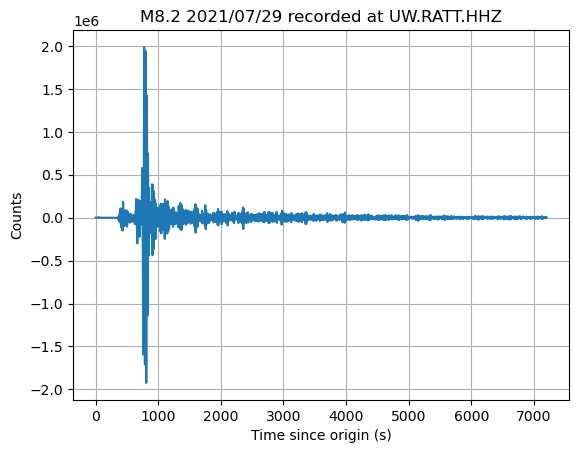

In [4]:
# plot the time series
T = np.linspace(0,(Tend-Tstart),Z[0].stats.npts)
plt.plot(T,Z[0].data)
plt.grid(True)
plt.xlabel('Time since origin (s)')
plt.title('M8.2 2021/07/29 recorded at UW.RATT.HHZ')
plt.ylabel('Counts')
plt.show()


Now, only seismologists work on obspy stream, so we will convert the data into numpy arrays:

In [5]:
z = np.asarray(Z[0].data)

To calculate the statistical features of the data, we will first look at the data distribution, P(z):

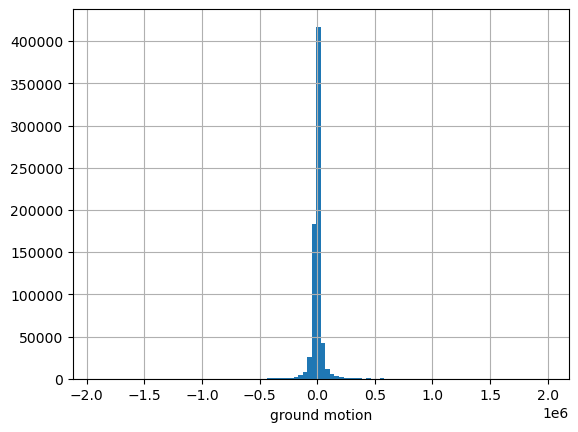

In [6]:
p = plt.hist(z,100);plt.grid(True);plt.xlabel('ground motion');plt.show()

We now calculated the distribution of the data, ``p``, in 100 bins.

## 2.6.2 Statistical Features

Let be $P(z)$ the distribution of the data $z$.

### The mean
<div>
<img src="mean.png" alt="mean" height=300  />
</div>

Image taken from this [blog](!https://gregorygundersen.com/blog/2020/04/11/moments).

The mean is the sum of the values divided by the number of data points. It is the first raw moment of a distribution. 
$\mu = \int_{-\infty}^\infty zP(z)dz$, where z is the ground motion value (bin) and $P(z)$ is the distribution of the data.

### The Variance
 <div>
<img src="variance.png" alt="variance" height=200  />
</div>

The variance is the second *centralized* moment. *Centralized* means that the distribution is shifted around the mean. It calculates how spread out is a distribution.

$\sigma^2 = \int_{-\infty}^\infty (z-\mu)^2P(z)dz$

The standard deviation is the square root of the variance, $\sigma$. A high variance indicates a wide distribution.

### The skewness

Skewness is the third *standardized* moment. The *standardized* moment is scaled by the standard deviation. It measures the relative size of the two tails of the distribution.


$m_3= \int_{-\infty}^\infty \frac{(z - \mu)^3}{\sigma^3}P(z)dz$

With the cubic exponent, it is possible that the skewness is negative.

 <div>
<img src="skewness.png" alt="skewness" height=200  />
</div>

Image taken from this [blog](!https://gregorygundersen.com/blog/2020/04/11/moments).

A positively skewed distribution is one where most of the weight is at the end of the distribution. A negatively skewed distribution is one where most of the weight is at the beginning of the distribution.


### Kurtosis

Kurtosis measures the combined size of the two tails relative to the whole distribution. It is the fourth centralized and standardized moment.

$m_4= \int_{-\infty}^\infty (\frac{z-\mu}{\sigma})^4P(z)dz$

 <div>
<img src="kurtosis.png" alt="kurtosis" height=200  />
</div>
The laplace, normal, and uniform distributions have a mean of 0 and a variance of 1. But their kurtosis is 3, 0, and -1.2.


Python functions to calculate the moments might be:

In [7]:
def raw_moment(X, k, c=0):
    return ((X - c)**k).mean()

def central_moment(X, k):
    return raw_moment(X=X, k=k, c=X.mean())


We can now calculate the mean, variance, skewness, and kurtosis of the data:


In [8]:
# enter answers here using the functions for the moment.
# the mean:
print(raw_moment(z,1))

# the variance:
print(central_moment(z,2))

# the skewness
print(central_moment(z,3)/central_moment(z,2)**(3/2))

# the kurtosis
print(central_moment(z,4)/central_moment(z,2)**2)



4.75361903901784e-13
19059318218.65704
0.144572326613743
109.22237948156209


We can also use the numpy and scipy modules to get these values

In [9]:
print('the mean is %4.2f, the variance is %4.2f, the skewness is %4.2f, the kurtosis is %4.2f'
 %(np.mean(z),np.std(z)**2,scipy.stats.skew(z),scipy.stats.kurtosis(z,fisher=False)))

the mean is 0.00, the variance is 19059318218.66, the skewness is 0.14, the kurtosis is 109.22


These values may mean nothing without some additional context. We can download seismic noise data to see if the earthquake waveforms are statistically different from the noise. For that, we will download the same length of data prior to the earthquake:

In [10]:
# Download seismic data 2 hours prior to the earthquake.
# modify below.
N = fdsn_client.get_waveforms(network=network, station=station, location='--', channel=channel, starttime=Tstart-7200, \
    endtime=Tstart, attach_response=True)
N.merge(); N.detrend(type='linear')
n=np.asarray(N[0].data)

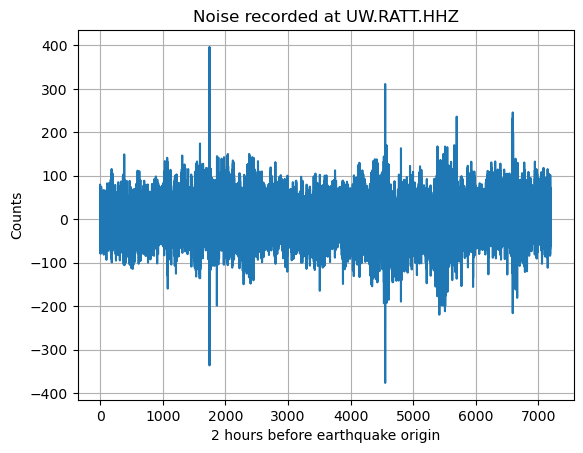

In [11]:
# plot the data
T = np.linspace(0,(Tend-Tstart),N[0].stats.npts)
plt.plot(T,n)
plt.grid(True)
plt.xlabel('2 hours before earthquake origin')
plt.title('Noise recorded at UW.RATT.HHZ')
plt.ylabel('Counts')
plt.show()

Calculate and plot the distribution of ground motion noise values:

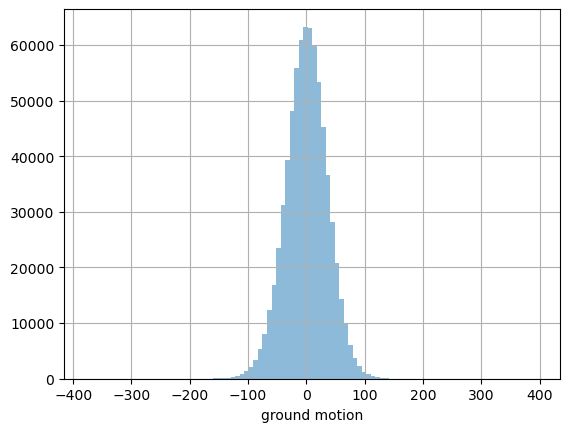

In [12]:
# type below
pn=plt.hist(n,100,alpha=0.5,label='noise');plt.grid(True);plt.xlabel('ground motion');plt.show()

In [13]:
print('the mean is %4.2f, the variance is %4.2f, the skewness is %4.2f, the kurtosis is %4.2f'
 %(np.mean(n),np.std(n)**2,scipy.stats.skew(n),scipy.stats.kurtosis(n,fisher=True)))

the mean is -0.00, the variance is 1273.08, the skewness is -0.09, the kurtosis is 0.39


Compare the values. You notice that for both quake and noise, the mean is small compared to absolute values; skewness is small (it's mostly symmetric). But the variance and the kurtosis are high for earthquakes. In fact, these two are used to detect earthquakes.



## Automated Feature Extraction

There are toolboxes to extract features from the data, including features from the tranfsform. We will use ``Tsfresh``, some of the best maintained and comprehensive python toolbox.

Most toolboxes require the input to be ``pandas``. First, we convert the data into pndas. 

In [1]:
!pip install tsfel

     |████████████████████████████████| 42 kB 1.3 MB/s eta 0:00:011
     |████████████████████████████████| 11.8 MB 3.0 MB/s eta 0:00:01
  Using cached tzdata-2023.3-py2.py3-none-any.whl (341 kB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.2
    Uninstalling pandas-1.5.2:
      Successfully uninstalled pandas-1.5.2


In [2]:
import tsfel

# we need to format the data for inputs in tsfresh.



We need to [format the data](!https://tsfresh.readthedocs.io/en/latest/text/data_formats.html) for input into tsfresh. It needs 1 column with the ``id`` (or label), one column for the time stamps (``sort``)

In [25]:

df=pd.DataFrame({'id':'A','quake':z[:len(n)],'noise':n})

SyntaxError: invalid syntax (680226577.py, line 1)

In [ ]:

extracted_features = extract_features(df, column_id="quake")

In [ ]:
extracted_features.head()


# create synthetic noise